### Exploratory Data Analysis -- the Wheelock Team

Notice: Upon the submission deadline on 2023/3/19, the team has not yet gained write access to the project's
directory, hence work has to be separately done on members' local machines on a small subset of the available data.


We also refer to the previous semester's EDA.
<br>
#### General findings
Since the project works with purely video data, normal quantized analysis method on quantitative/qualitative data attributes
could not be done. Instead, the team adopts manual examination of a few sample clips as an initial step,
and a few problems have emerged:<br>
1. Since the video clips are uploaded by teachers, uniform specifications across clips do not exist.
    1. Videos could be either shot on phone or by camera, in landscape or portrait layout, and have various resolutions.
    2. Nature of the courses vary a lot, causing the actions and behaviors of students that appear in videos to be very unpredictable.
    3. Although teachers submit a pdf report on the subject of the course, the report itself is neither mandatory nor
formatted, so it can't be used as an easy method for grouping the clips.

2. As a continuation from the previous bullet point, video can be shot from any position in the classroom, with different views
of the students/teachers on camera.

3. All video clips are unlabeled, so the team cannot adopt any supervised learning method on the dataset.

Considering the unlabeled and fickle nature of the dataset, the team has decided on using unsupervised grouping methods once the feature vectors have been extracted using a pretrained feature extraction model. 

#### Video aquisition on SCC
Once write access is granted on SCC project directory, the team plans to deploy the following code to fetch all available video clips as the full dataset.

In [ ]:
import re
import os
import glob
import fnmatch
import pathlib

In [ ]:
path = "./teach-forward-videos"
pattern = "*.mp4"

file_list = []

for dirpath, dirnames, filenames in os.walk(path):
    if not filenames:
        continue

    files = fnmatch.filter(filenames, pattern)
    if files:
        for file in files:
            file_with_path = '{}/{}'.format(dirpath, file)
            file_list.append(file_with_path)
print(file_list)

#### Basic Information Acquired Using ffmprobe
To begin with, we used ffmprobe, a tool included in package ffmpeg, to acquire some basic information about the dataset.

In [ ]:
for filename in file_list:
    filename = filename[2:]
    !ffprobe -v error -hide_banner -of default=noprint_wrappers=0 -print_format flat -select_streams v:0 -show_entries stream=width,height /projectnb/sparkgrp/ml-wheelock-video-grp{filename}

The above code, running in the project's source directory, prints all the videos' heights and widths, and we found out that all clips were 854x480, which means that they are typical 16:9 480p videos.

In [ ]:
for filename in file_list:
    filename = filename[2:]
    !ffprobe -v error -hide_banner -of default=noprint_wrappers=0 -print_format csv -select_streams v:0 -show_entries stream=bit_rate /projectnb/sparkgrp/ml-wheelock-video-grp{filename}

With simple modifications, ffmprobe is also capable of returning the bitrate of all the clips. We include a histogram of them here: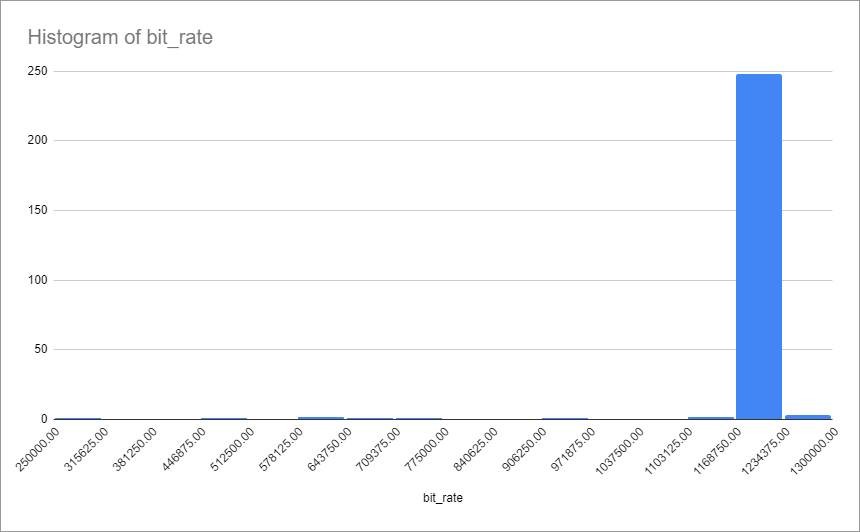

From the above histogram, it can be observed that most clips have a bitrate of around 1,200,000. 

In [ ]:
for filename in file_list:
    filename = filename[2:]
    !ffprobe -v error -hide_banner -of default=noprint_wrappers=0 -print_format csv -select_streams v:0 -show_entries stream=duration /projectnb/sparkgrp/ml-wheelock-video-grp{filename}

Similarly, the clip durations are gathered and presented in another histogram using the above code: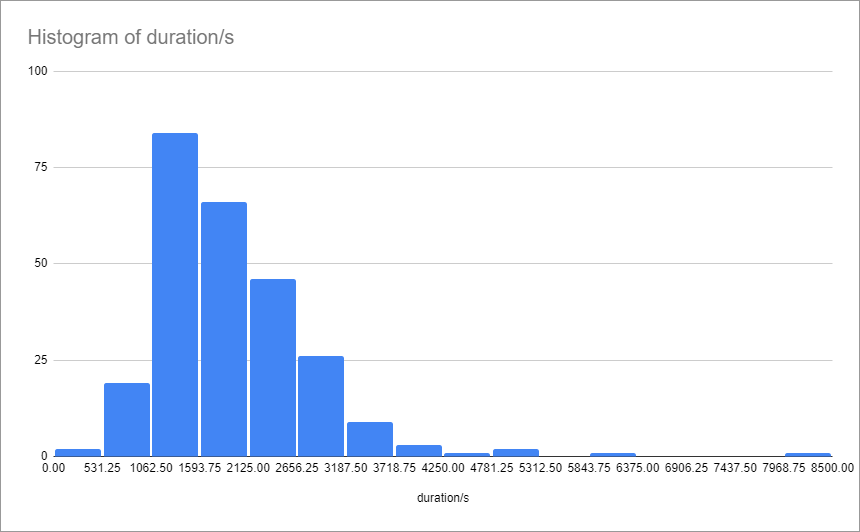

The distribution of durations are rather scattered, but the most popular category is between 1060 and 1600s, which is around 18-27 minutes.

If the above images aren't loading corretly, viewers are encouraged to access the original excel file: https://docs.google.com/spreadsheets/d/1V3L5bw28pIURqJugxRcH3zY2To57Cl3KJn-empKWYCQ/edit?usp=sharing

#### Video Super Resolution
To test video super resolution on an MP4 video file using BasicVSR++, run the following line of code with the correct paths for the input video file and the output folder:

In [ ]:
!pip install jedi
!pip install ipython==7.9.0
!pip install torch torchvision
!pip install openmim
#!pip install mmcv-full>=1.3.13,<1.6.0
!pip install mmcv-full==1.6.0
!pip install mmedit==0.6.0
!git clone https://github.com/ckkelvinchan/BasicVSR_PlusPlus.git
%cd BasicVSR_PlusPlus
!pip install -e .

You can find the pre-trained weights using the code below

In [ ]:
!wget https://www.dropbox.com/sh/gopo637rbutlxde/AACGnXDlvQMjwfCey3m2g34za?dl=0 -P chkpts/

You can also download the VSR checkpoint from this link: https://download.openmmlab.com/mmediting/restorers/basicvsr_plusplus/basicvsr_plusplus_c64n7_8x1_600k_reds4_20210217-db622b2f.pth

In [ ]:
!python demo/restoration_video_demo.py configs/basicvsr_plusplus_reds4.py /content/BasicVSR_PlusPlus/chkpts/basicvsr_plusplus_reds4.pth /content/BasicVSR_PlusPlus/data/3c5ea671-video.mp4 /content/results/output.mp4


#### Quantized Video Quality Assessment
As directed by the professor, the team has found & locally deployed a video quality quantization tool _vmaf_ developed by _Netflix_. It takes a pair of video clips at the same resolution, uses one as the reference and outputs the "quality" of the other video. In our usecase, we had the output from the super resolution model as reference and tested the quality of the video before super resolution, as an attempt to uniformly improve video quality in the dataset. Unfortunately, _vmaf_ was a command line tool and the team could not get its Python wrapper working on local machines by the EDA deadline. _vmaf_ commands are placed below as a reference:

```
./build/tools/vmaf \
    --reference reference_clip.yuv \
    --distorted src01_hrc01_576x324.yuv \
    --width 576 --height 324 --pixel_format 420 --bitdepth 8 \
    --model version=vmaf_v0.6.1 \
    --feature psnr \
    --output output.xml
```  

As a reference, the team also looks at the vmaf scores of comparing the clip with itself, and the scores scatter around 98. Based on this result, the team decides to not include the super-resolution model in the final pipeline due to the following reasons:
1. The team did not see significant improvements when comparing the vmaf scores (90+ for original clips against upsampled clips and around 98 for upsampled clips against themselves)
2. Neither the super-resolution model nor vmaf incorporates well into a Jupyter Notebook workflow. 
3. Video clips would have to go through down-sample eventually before feature extraction takes place, further reducing the necessity of super-resoltion.
